In [302]:
import pandas as pd
import os
from scipy import stats
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [303]:
listings = pd.read_csv(f"insideairbnb/listings.csv/listings.csv")

In [304]:
listings['host_since'] = pd.to_datetime(listings['host_since'], format='%Y-%m-%d')
listings.set_index('host_since', inplace=True)
host_since = listings.groupby(pd.Grouper(freq='Y')).size()
host_since.index = host_since.index.strftime('%Y')
print("\nHost since:\n", host_since)



Host since:
 host_since
2008       1
2009      34
2010     279
2011    1069
2012    1734
2013    1715
2014    1192
2015    1921
2016    1356
2017    1408
2018    1279
2019    1586
2020    1560
2021     988
2022    1065
2023    1178
2024     558
dtype: int64


Barcelona has some of the strictest short-term rental regulations in Europe. Since 2014, the city has stopped issuing new tourist licenses for short-term rentals in an effort to curb the rapid growth of vacation rentals. As a result, the only way to legally operate a short-term rental in Barcelona is to purchase a property that already has a valid tourist license.

We expect the growth in the amount of Airbnb hosts to dramatically stop in 2014 as a result of this limitation

In [305]:
host_since_df = host_since.reset_index()
host_since_df.columns = ['Date', 'New hosts']
host_since_df = host_since_df[host_since_df['Date']!='2024']

In [306]:
host_since_df['Date'] = host_since_df['Date'].apply(lambda x : int(x))

In [307]:
before_2014 = host_since_df[host_since_df['Date'] <= 2014]
after_2014 = host_since_df[host_since_df['Date'] >= 2014]

# Fit linear regression models
slope_before, intercept_before, r_value, p_value, std_err = stats.linregress(before_2014['Date'], before_2014['New hosts'])
slope_after, intercept_after, r_value, p_value, std_err = stats.linregress(after_2014['Date'], after_2014['New hosts'])

host_since_df['3-year MA'] = host_since_df['New hosts'].rolling(window=3).mean()

C:\Users\danie\AppData\Local\Temp\ipykernel_23688\1340177359.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(before_2014['Date'], intercept_before + slope_before*before_2014['Date'], 'g-', label='Trend before 2014', linestyle='--')
C:\Users\danie\AppData\Local\Temp\ipykernel_23688\1340177359.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(after_2014['Date'], intercept_after + slope_after*after_2014['Date'], 'r-', label='Trend after 2014', linestyle='--')


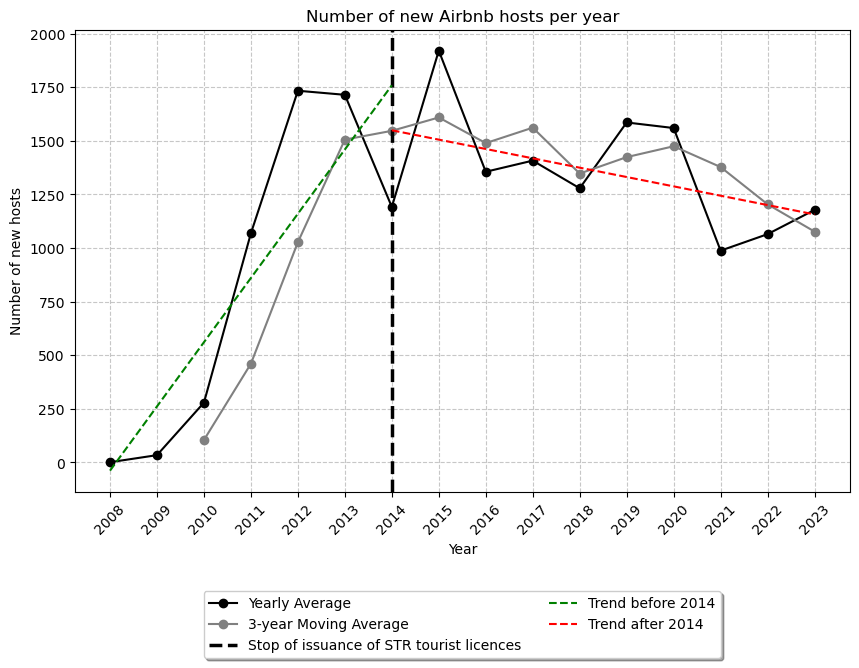

In [308]:
plt.figure(figsize=(10, 6))
plt.plot(host_since_df['Date'], host_since_df['New hosts'], color='black', marker='o', label='Yearly Average')
plt.plot(host_since_df['Date'], host_since_df['3-year MA'], color='grey', marker='o', label='3-year Moving Average')
plt.title('Number of new Airbnb hosts per year')
plt.xlabel('Year')
plt.ylabel('Number of new hosts')
plt.xticks(host_since_df['Date'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2014,  linestyle='--', linewidth=2.5, color='black', label='Stop of issuance of STR tourist licences')
plt.plot(before_2014['Date'], intercept_before + slope_before*before_2014['Date'], 'g-', label='Trend before 2014', linestyle='--')
plt.plot(after_2014['Date'], intercept_after + slope_after*after_2014['Date'], 'r-', label='Trend after 2014', linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)
plt.show()

In [309]:
'''
listings.dropna(subset='price', inplace=True)
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].str.replace('^\$(\d+)\.00$', r'\1', regex=True)
listings['price'] = listings['price'].apply(lambda x: int(x))
listings.reset_index(inplace=True)
'''

"\nlistings.dropna(subset='price', inplace=True)\nlistings['price'] = listings['price'].str.replace(',','')\nlistings['price'] = listings['price'].str.replace('^\\$(\\d+)\\.00$', r'\x01', regex=True)\nlistings['price'] = listings['price'].apply(lambda x: int(x))\nlistings.reset_index(inplace=True)\n"

#### Checking tourist license compliance

In [310]:
len(listings[listings['license'].isna()==True])

6138

In [311]:
len(listings[listings['license']=='Exempt'])

5094

In [312]:
listings[~listings['license'].str.lower().str.startswith('h', na=False)]['license'].unique()

array(['N/A SOLO ESTANCIAS MENSUALES', 'Exempt', nan,
       'Only seasonal rental (32 nights min) according to Spanish law (LAU/Ley de Arrendamientos Urbanos)',
       '0168028-0', 'Pendiente de trámite', 'AJ116959', 'AJ000511',
       'AJ051185', '0260815-0',
       'Numero registro:  0568050-0. Expediente: 05-2013-0629',
       '0215518-N', '10019674T', 'AJ000604', '0474176-0',
       '+34 610 220 990', 'Ref. HUTB-014226',
       'Período mínimo de alquiler 32 días', 'Media Estancia', '2o 1a',
       'LY-2012-3-15-01297457',
       'NIF B62643549 ALQUILER POR TEMPORADA MAS DE 31 DIAS', '37291320V',
       'Carrera de la purissima 37', 'ATB-000086', '36569531Z',
       'Periodo minimo de alquiler 32 dias', 'AJ-000533', 'AJ-000534',
       'ATB-000089', '1601415 llicència', 'AJ000651',
       'No needed since it is a monthly rental',
       'Temporada sup 32 noches', '32 nights minimum stay.', 'B66448176',
       'AJ-000581', 'AJ-000582', 'AJ000621', 'asd-123456', 'AJ-000622',
       

#### BARCELONA STR BAN

We can already see that there are several descriptions pointing out how the Airbnb lacks a valid tourist license for short term rental, because the property is only rentable for a minimum of 32 nights. In fact, in August 2021, additional short-term rental regulations in Barcelona were introduced in order to limit the amount of short-term room rentals.

The Barcelona Airbnb ban prevents hosts from renting out a room only for less than 31 days. If you wish to rent accommodation for more than 31 days, whether it’s a whole property or just a room, you are able to do so but this will not be considered as tourist accommodation. Any rental with a time period of over 31 days is therefore long-term.

#### Checking minimum nights setting

In [313]:
minimum_nights = listings.minimum_nights.value_counts().sort_index()
minimum_nights = minimum_nights.reset_index()
minimum_nights.columns = ['minimum_nights', 'count']
minimum_nights = minimum_nights[minimum_nights['count']>2]

In [314]:
minimum_nights['type_of_stay'] = minimum_nights['minimum_nights'].apply(lambda x: 'Long stay' if x>31 else 'Short stay')

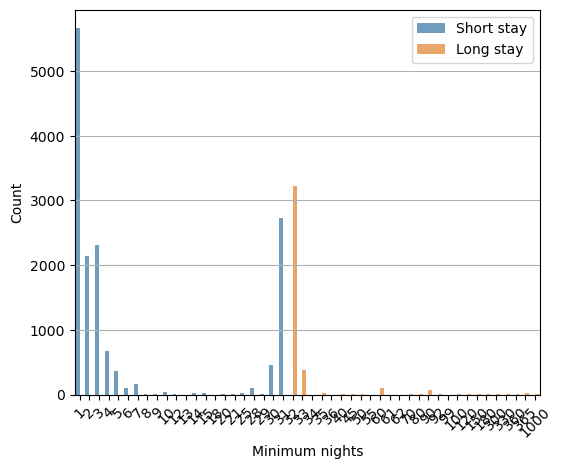

In [315]:
plt.figure(figsize=(6,5))
sns.barplot(x = 'minimum_nights', y='count', data = minimum_nights, hue='type_of_stay', alpha=0.7)
plt.xlabel('Minimum nights')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### _Reviews.csv_ file

In [316]:
reviews = pd.read_csv("insideairbnb//reviews.csv")
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')
reviews.set_index('date', inplace=True)
reviews.head()

,listing_id
date,
2018-01-01,269467
2013-05-27,18674
2018-03-30,269467
2018-04-04,269467
2014-03-02,18674


In [317]:
yearly_counts = reviews.groupby(pd.Grouper(freq='Y')).size()
yearly_counts.index = yearly_counts.index.strftime('%Y')
# Display the monthly counts
print("\nYearly Counts:\n", yearly_counts)


Yearly Counts:
 date
2010         4
2011       173
2012       931
2013      4457
2014     13125
2015     25920
2016     43233
2017     59745
2018     77106
2019    105012
2020     29018
2021     60669
2022    154229
2023    199986
2024    108655
dtype: int64


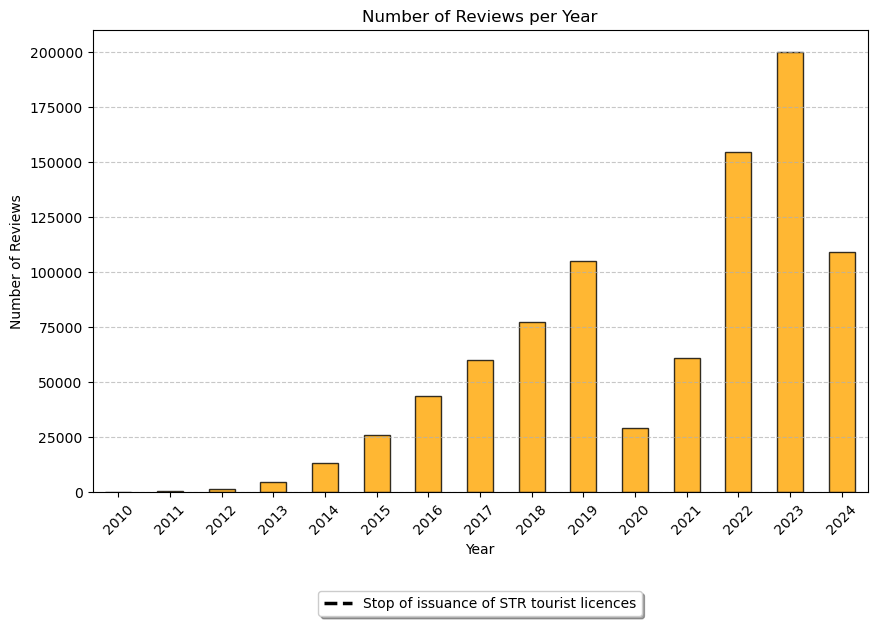

In [318]:
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar', color='orange', edgecolor='black', alpha=0.8)
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=2014,  linestyle='--', linewidth=2.5, color='black', label='Stop of issuance of STR tourist licences')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)
plt.show()

In [319]:
sales = pd.read_excel("Precio medio oferta distritos barcelona.xlsx", header=0)

In [320]:
sales = sales.rename(columns={'Distritos': 'Distretto', 'Años\xa0\xa0\xa0\xa0\xa0\xa0\xa0': 'Anno', '1r trimestre\xa0\xa0': 'Trimestre 1', '2º trimestre\xa0\xa0': 'Trimestre 2', '3º trimestre\xa0\xa0': 'Trimestre 3', '4º trimestre\xa0\xa0': 'Trimestre 4'})
sales.head()

,Distretto,Anno,Trimestre 1,Trimestre 2,Trimestre 3,Trimestre 4
0,BARCELONA,2001,-,2.010,2.085,2.115
1,1. Ciutat Vella,2001,-,1.761,1.797,1.947
2,2. Eixample,2001,-,1.907,2.331,2.448
3,3. Sants-Montjuïc,2001,-,1.931,1.886,1.867
4,4. Les Corts,2001,-,2.281,2.522,2.842


In [321]:
for col in sales.columns:
  sales[col] = sales[col].str.strip()
  if col!='Distretto':
    sales[col] = sales[col].str.replace('.', '', regex=False)
    sales[col] = pd.to_numeric(sales[col], errors='ignore')
  else:
    sales[col] = sales[col].str.replace(r'^\d+\.\s*', '', regex=True)


In [322]:
sales = sales[sales['Anno'] > 2010]
sales.head()

,Distretto,Anno,Trimestre 1,Trimestre 2,Trimestre 3,Trimestre 4
110,BARCELONA,2011,3782,3632,3533,3434
111,Ciutat Vella,2011,3440,3197,3083,2981
112,Eixample,2011,4057,3923,3806,3696
113,Sants-Montjuïc,2011,3085,2998,2877,2767
114,Les Corts,2011,4746,4523,4356,4298


In [323]:
sales['Trimestre 1'] = pd.to_numeric(sales['Trimestre 1'])

In [324]:
sales['Media annuale'] = (sales['Trimestre 1'] + sales['Trimestre 2'] + sales['Trimestre 3'] + sales['Trimestre 4']) / 4
sales.head(15)

,Distretto,Anno,Trimestre 1,Trimestre 2,Trimestre 3,Trimestre 4,Media annuale
110,BARCELONA,2011,3782,3632,3533,3434,3595.25
111,Ciutat Vella,2011,3440,3197,3083,2981,3175.25
112,Eixample,2011,4057,3923,3806,3696,3870.50
113,Sants-Montjuïc,2011,3085,2998,2877,2767,2931.75
114,Les Corts,2011,4746,4523,4356,4298,4480.75
115,Sarrià-Sant Gervasi,2011,4773,4629,4459,4321,4545.50
116,Gràcia,2011,3750,3574,3462,3375,3540.25
117,Horta-Guinardó,2011,3003,2876,2827,2700,2851.50
118,Nou Barris,2011,2650,2527,2505,2356,2509.50
119,Sant Andreu,2011,2911,2820,2704,2590,2756.25


In [325]:
agg_sales = sales[sales['Distretto']=='BARCELONA']
agg_sales

,Distretto,Anno,Trimestre 1,Trimestre 2,Trimestre 3,Trimestre 4,Media annuale
110,BARCELONA,2011,3782,3632,3533,3434,3595.25
121,BARCELONA,2012,3332,3260,3202,3114,3227.00
132,BARCELONA,2013,3045,3035,2957,3019,3014.00
143,BARCELONA,2014,3067,3100,3116,3188,3117.75
154,BARCELONA,2015,3263,3293,3401,3392,3337.25
165,BARCELONA,2016,3478,3533,3667,3879,3639.25
176,BARCELONA,2017,4123,4253,4335,4284,4248.75
187,BARCELONA,2018,4334,4400,4388,4344,4366.50
198,BARCELONA,2019,4217,4206,4205,4115,4185.75
209,BARCELONA,2020,4111,4163,4083,4009,4091.50


In [326]:
before_2017 = agg_sales[agg_sales['Anno'] <= 2017]
after_2017 = agg_sales[agg_sales['Anno'] >= 2017]

# Fit linear regression models
slope_before, intercept_before, r_value, p_value, std_err = stats.linregress(before_2017['Anno'], before_2017['Media annuale'])
slope_after, intercept_after, r_value, p_value, std_err = stats.linregress(after_2017['Anno'], after_2017['Media annuale'])
agg_sales['3-year MA'] = agg_sales['Media annuale'].rolling(window=3).mean()


C:\Users\danie\AppData\Local\Temp\ipykernel_23688\889646947.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_sales['3-year MA'] = agg_sales['Media annuale'].rolling(window=3).mean()


C:\Users\danie\AppData\Local\Temp\ipykernel_23688\1193400788.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(before_2017['Anno'], intercept_before + slope_before*before_2017['Anno'], 'g-', label='Trend before 2017', linestyle='--')
C:\Users\danie\AppData\Local\Temp\ipykernel_23688\1193400788.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(after_2017['Anno'], intercept_after + slope_after*after_2017['Anno'], 'r-', label='Trend after 2017', linestyle='--')


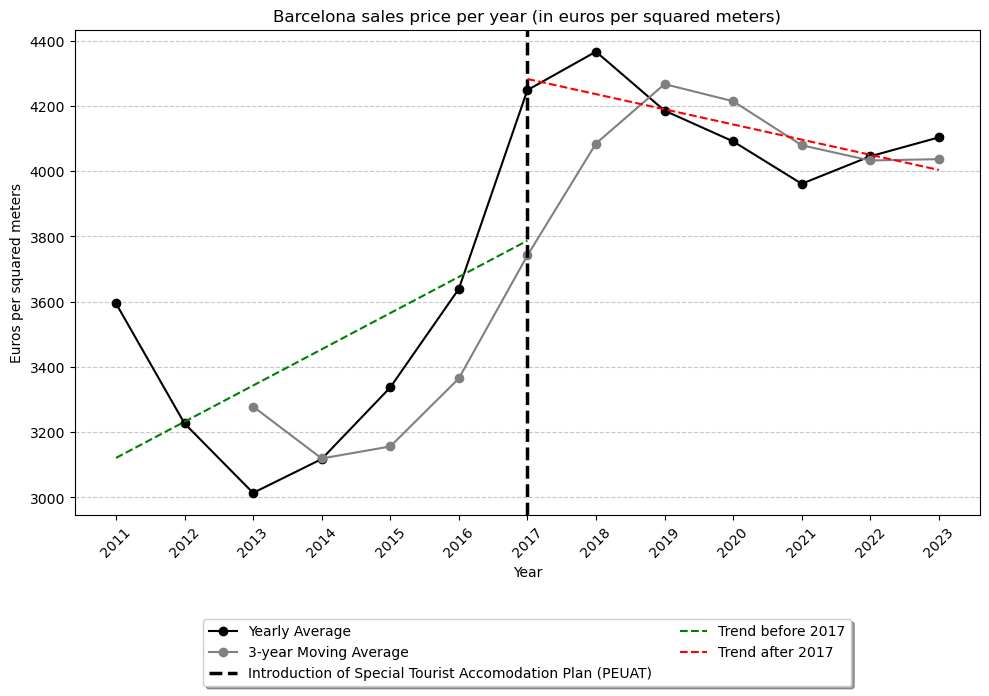

In [327]:
plt.figure(figsize=(10, 6))
# plt.bar(agg_rents['Anno'], agg_rents['Media annuale'], color='skyblue', edgecolor='black')
plt.plot(agg_sales['Anno'], agg_sales['Media annuale'], color='black', linestyle='-', marker='o', label='Yearly Average')
plt.plot(agg_sales['Anno'], agg_sales['3-year MA'], color='grey', linestyle='-', marker='o', label='3-year Moving Average')
plt.title('Barcelona sales price per year (in euros per squared meters)')
plt.xlabel('Year')
plt.ylabel('Euros per squared meters')
plt.xticks(agg_sales['Anno'], rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=2017,  linestyle='--', linewidth=2.5, color='black', label='Introduction of Special Tourist Accomodation Plan (PEUAT)')
plt.plot(before_2017['Anno'], intercept_before + slope_before*before_2017['Anno'], 'g-', label='Trend before 2017', linestyle='--')
plt.plot(after_2017['Anno'], intercept_after + slope_after*after_2017['Anno'], 'r-', label='Trend after 2017', linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)
plt.show()

In [328]:
district_avg = sales.groupby(['Distretto','Anno']).mean('Media annuale')['Media annuale']
district_avg = district_avg.reset_index()

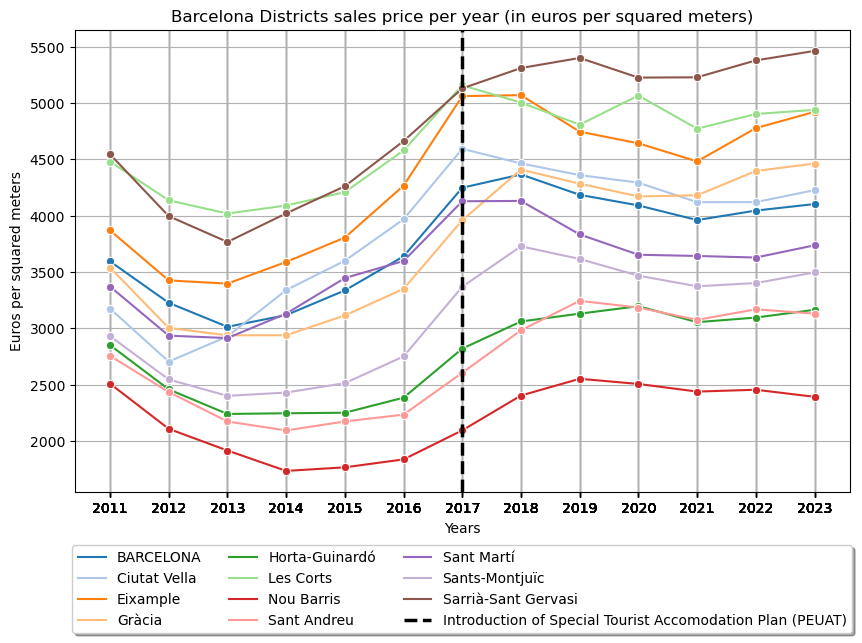

In [329]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=district_avg, x='Anno', y='Media annuale', hue='Distretto', palette='tab20', marker='o')

plt.title('Barcelona Districts sales price per year (in euros per squared meters)')
plt.xlabel('Years')
plt.ylabel('Euros per squared meters')
plt.xticks(district_avg['Anno'])
plt.grid(True)
plt.axvline(x=2017,  linestyle='--', linewidth=2.5, color='black', label='Introduction of Special Tourist Accomodation Plan (PEUAT)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)
plt.show()

The PEUAT introduced special restrictions for "zonas especificas" (ZE). These specific zone range from "ZE1" subject to the most stringent regulations to "ZE4" that are impacted by the regulation in a mild way. Notably, the neighbourhood _Sant Andreu_ is included in "ZE3", with its predominant area called _La Sagrera_ being classified as ZE4. This means that this neighborhood has been impacted relatively less than others by the introduction of the PEUAT in 2017.
In fact, _Sant Andreu_ district has undergone the most substantial percent increase in sales prices in the entire of Barcelona.

In [330]:
df_2017 = district_avg[district_avg['Anno'] == 2017][['Distretto', 'Media annuale']].rename(columns={'Media annuale': 'Media 2017'})
df_2023 = district_avg[district_avg['Anno'] == 2023][['Distretto', 'Media annuale']].rename(columns={'Media annuale': 'Media 2023'})

# Merge on 'Distretto'
sales_price_difference = pd.merge(df_2023, df_2017, on='Distretto')

# Calculate the difference
sales_price_difference['Percent change'] = round(((sales_price_difference['Media 2023'] - sales_price_difference['Media 2017']) * 100/ sales_price_difference['Media 2017']),2)
# sales_price_difference['Percent change'] = sales_price_difference['Percent change'].apply(lambda x: str(x) + '%')
# Display the result
print(sales_price_difference[['Distretto', 'Percent change']])


              Distretto  Percent change
0             BARCELONA           -3.41
1          Ciutat Vella           -7.99
2              Eixample           -2.76
3                Gràcia           12.70
4        Horta-Guinardó           12.22
5             Les Corts           -4.23
6            Nou Barris           14.21
7           Sant Andreu           20.13
8            Sant Martí           -9.47
9        Sants-Montjuïc            3.77
10  Sarrià-Sant Gervasi            6.49


In [331]:
sales_price_difference['Delta'] = sales_price_difference['Percent change'].apply(lambda x: 'Positive' if x>0 else 'Negative')
sales_price_difference.loc[sales_price_difference['Percent change'] == max(sales_price_difference['Percent change']),'Delta'] = 'Highest'
sales_price_difference

,Distretto,Media 2023,Media 2017,Percent change,Delta
0,BARCELONA,4103.75,4248.75,-3.41,Negative
1,Ciutat Vella,4227.00,4594.25,-7.99,Negative
2,Eixample,4922.25,5062.00,-2.76,Negative
3,Gràcia,4463.50,3960.50,12.70,Positive
4,Horta-Guinardó,3165.25,2820.50,12.22,Positive
5,Les Corts,4939.75,5157.75,-4.23,Negative
6,Nou Barris,2392.50,2094.75,14.21,Positive
7,Sant Andreu,3131.00,2606.25,20.13,Highest
8,Sant Martí,3737.50,4128.50,-9.47,Negative
9,Sants-Montjuïc,3496.75,3369.75,3.77,Positive


<Figure size 1000x600 with 0 Axes>

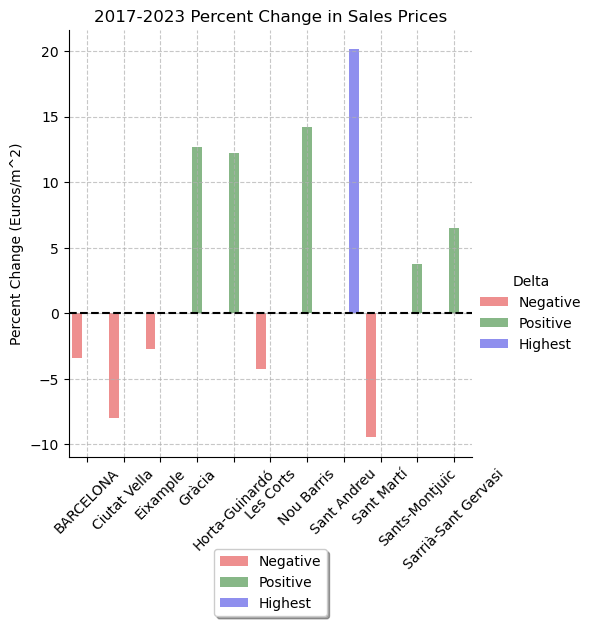

In [332]:
plt.figure(figsize=(10, 6))
sns.catplot(x = 'Distretto', y = 'Percent change', data = sales_price_difference, kind='bar', hue='Delta', palette={'Positive': 'green', 'Negative': 'red', 'Highest': 'blue'}, alpha=0.5)
plt.title('2017-2023 Percent Change in Sales Prices')
plt.xlabel('District')
plt.ylabel('Percent Change (Euros/m^2)')
plt.xticks(ticks=range(len(sales_price_difference['Distretto'].unique())), labels=sales_price_difference['Distretto'].unique(), rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, linestyle='--', linewidth=1.5, color='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True)
plt.show()

The _Sant Andreu_ neighbourhood has undergone the most dramatic increase in sales price.

In [333]:
rental = pd.read_csv("Barcelona_rent_price.csv")
rental['District'].unique()

array(['Ciutat Vella', 'Eixample', 'Sants-Montjuic', 'Les Corts',
       'Sarria-Sant Gervasi', 'Gracia', 'Horta-Guinardo', 'Nou Barris',
       'Sant Andreu', 'Sant Marti'], dtype=object)

In [334]:
rental = rental[rental['Average _rent']=='average rent per surface (euro/m2)']

In [335]:
rental = rental.groupby('Year').mean('Price')

In [336]:
rental = rental.reset_index()
rental

,Year,Trimester,Price
0,2014,2.490842,9.726777
1,2015,2.507246,10.453043
2,2016,2.489130,11.494239
3,2017,2.498168,12.638059
4,2018,2.503704,12.819444
5,2019,2.505576,13.374349
6,2020,2.490706,13.321190
7,2021,2.503704,12.720741
8,2022,1.503704,13.354815


In [337]:
before_2017_rent = rental[rental['Year'] <= 2017]
after_2017_rent = rental[rental['Year'] >= 2017]

# Fit linear regression models
slope_before_rent, intercept_before_rent, r_value_rent, p_value_rent, std_err_rent = stats.linregress(before_2017_rent['Year'], before_2017_rent['Price'])
slope_after_rent, intercept_after_rent, r_value_rent, p_value_rent, std_err_rent = stats.linregress(after_2017_rent['Year'], after_2017_rent['Price'])
rental['3-year MA'] = rental['Price'].rolling(window=3).mean()


C:\Users\danie\AppData\Local\Temp\ipykernel_23688\2228061140.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(before_2017_rent['Year'], intercept_before_rent + slope_before_rent*before_2017_rent['Year'], 'g-', label='Trend before 2017', linestyle='--')
C:\Users\danie\AppData\Local\Temp\ipykernel_23688\2228061140.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(after_2017_rent['Year'], intercept_after_rent + slope_after_rent*after_2017_rent['Year'], 'r-', label='Trend after 2017', linestyle='--')


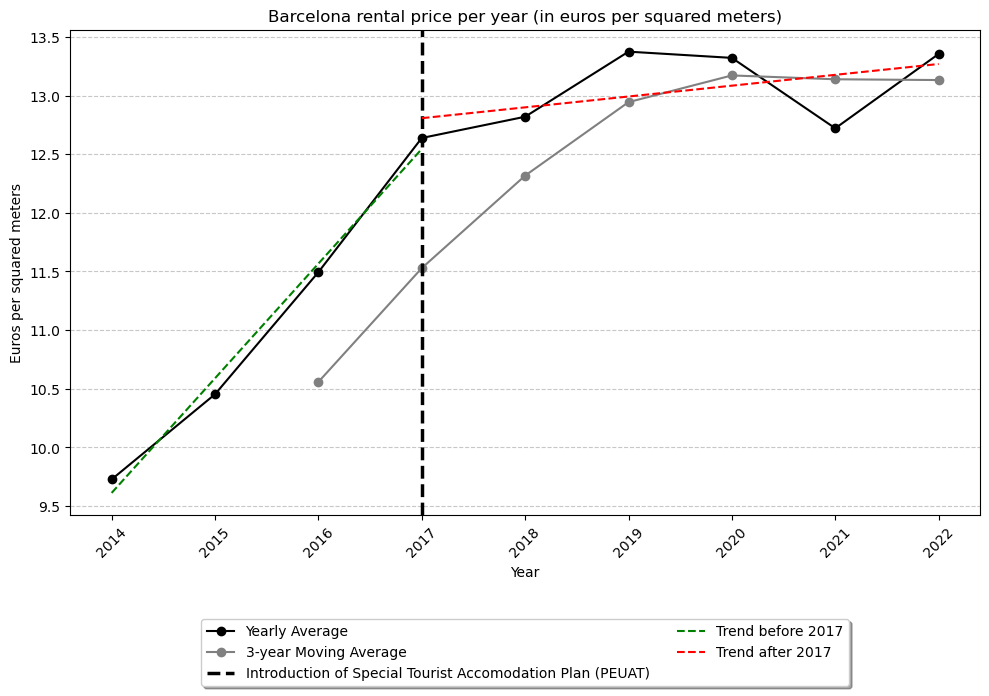

In [338]:
plt.figure(figsize=(10, 6))
# plt.bar(agg_rents['Anno'], agg_rents['Media annuale'], color='skyblue', edgecolor='black')
plt.plot(rental['Year'], rental['Price'], color='black', linestyle='-', marker='o', label='Yearly Average')
plt.plot(rental['Year'], rental['3-year MA'], color='grey', linestyle='-', marker='o', label='3-year Moving Average')
plt.title('Barcelona rental price per year (in euros per squared meters)')
plt.xlabel('Year')
plt.ylabel('Euros per squared meters')
plt.xticks(rental['Year'], rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=2017,  linestyle='--', linewidth=2.5, color='black', label='Introduction of Special Tourist Accomodation Plan (PEUAT)')
plt.plot(before_2017_rent['Year'], intercept_before_rent + slope_before_rent*before_2017_rent['Year'], 'g-', label='Trend before 2017', linestyle='--')
plt.plot(after_2017_rent['Year'], intercept_after_rent + slope_after_rent*after_2017_rent['Year'], 'r-', label='Trend after 2017', linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)
plt.show()

In [339]:
print(f'The slope of the trend for the rental prices after the PEUAT measure is {slope_after_rent:.3f}')
print(f'The slope of the trend for the rental prices before the PEUAT measure is {slope_before_rent:.3f}')

The slope of the trend for the rental prices after the PEUAT measure is 0.092
The slope of the trend for the rental prices before the PEUAT measure is 0.978


In [340]:
print(f"The ratio for the rental prices between the trend after the PEUAT measure and the trend before is: {(slope_after_rent / slope_before_rent):.3f}")

The ratio for the rental prices between the trend after the PEUAT measure and the trend before is: 0.095


In [341]:
print(f'The slope of the trend for the sales prices after the PEUAT measure is {slope_after:.3f}')
print(f'The slope of the trend for the sales prices before the PEUAT measure is {slope_before:.3f}')

The slope of the trend for the sales prices after the PEUAT measure is -46.455
The slope of the trend for the sales prices before the PEUAT measure is 111.009


In [342]:
print(f"The ratio for the sales prices between the trend after the PEUAT measure and the trend before is: {(slope_after / slope_before):.3f}")

The ratio for the sales prices between the trend after the PEUAT measure and the trend before is: -0.418


There is greater impact of the PEUAT measure on the sales price than on the rental price.

In [343]:
rental = pd.read_csv("Barcelona_rent_price.csv")
rental = rental[rental['Average _rent']=='average rent per surface (euro/m2)']
rental

,Year,Trimester,District,Neighbourhood,Average _rent,Price
273,2014,1,Ciutat Vella,el Raval,average rent per surface (euro/m2),10.76
274,2014,1,Ciutat Vella,Gothic Quarter,average rent per surface (euro/m2),10.58
275,2014,1,Ciutat Vella,la Barceloneta,average rent per surface (euro/m2),14.40
276,2014,1,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",average rent per surface (euro/m2),11.01
277,2014,1,Eixample,Fort Pienc,average rent per surface (euro/m2),10.42
...,...,...,...,...,...,...
4617,2022,2,Sant Marti,Diagonal Mar i el Front Maritim del Poblenou,average rent per surface (euro/m2),17.50
4618,2022,2,Sant Marti,el Besos i el Maresme,average rent per surface (euro/m2),12.20
4619,2022,2,Sant Marti,Provencals del Poblenou,average rent per surface (euro/m2),14.60
4620,2022,2,Sant Marti,Sant Marti de Provencals,average rent per surface (euro/m2),11.90


In [344]:
district_avg_rent = rental.groupby(['District','Year']).mean('Price')['Price'].reset_index()
district_avg_rent

,District,Year,Price
0,Ciutat Vella,2014,11.851250
1,Ciutat Vella,2015,12.840000
2,Ciutat Vella,2016,14.388125
3,Ciutat Vella,2017,15.908750
4,Ciutat Vella,2018,14.932500
...,...,...,...
85,Sarria-Sant Gervasi,2018,15.192083
86,Sarria-Sant Gervasi,2019,15.654167
87,Sarria-Sant Gervasi,2020,15.308333
88,Sarria-Sant Gervasi,2021,15.012500


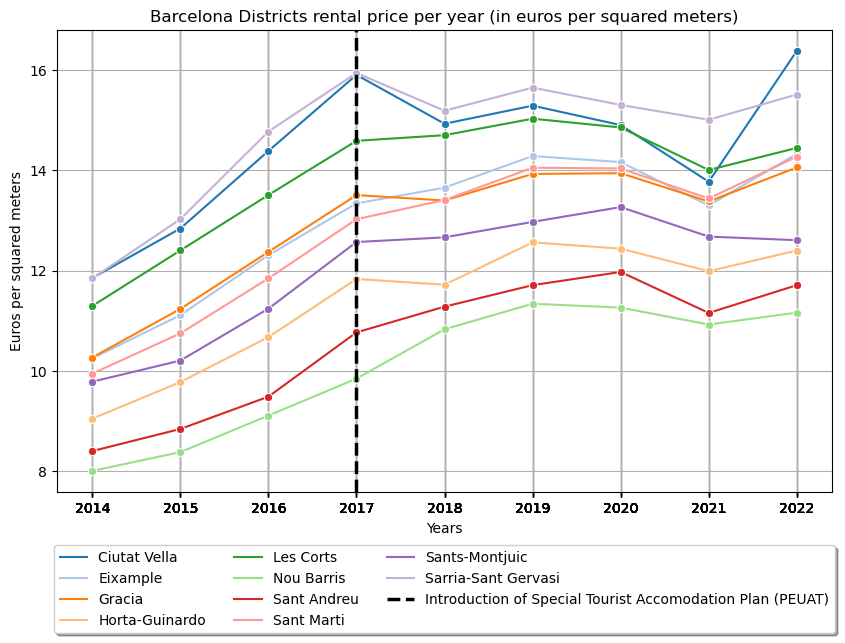

In [345]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=district_avg_rent, x='Year', y='Price', hue='District', palette='tab20', marker='o')

plt.title('Barcelona Districts rental price per year (in euros per squared meters)')
plt.xlabel('Years')
plt.ylabel('Euros per squared meters')
plt.xticks(district_avg_rent['Year'])
plt.grid(True)
plt.axvline(x=2017,  linestyle='--', linewidth=2.5, color='black', label='Introduction of Special Tourist Accomodation Plan (PEUAT)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)
plt.show()

The PEUAT introduced special restrictions for "zonas especificas" (ZE). These specific zone range from "ZE1" subject to the most stringent regulations to "ZE4" that are impacted by the regulation in a mild way. Notably, the neighbourhood _Sant Andreu_ is included in "ZE3", with its predominant area called _La Sagrera_ being classified as ZE4. This means that this neighborhood has been impacted relatively less than others by the introduction of the PEUAT in 2017.
In fact, _Sant Andreu_ district has undergone the most substantial percent increase in sales prices in the entire of Barcelona.

In [346]:
df_2017_rent = district_avg_rent[district_avg_rent['Year'] == 2017][['District', 'Price']].rename(columns={'Price': 'Average price 2017'})
df_2022_rent = district_avg_rent[district_avg_rent['Year'] == 2022][['District', 'Price']].rename(columns={'Price': 'Average price 2022'})

# Merge on 'Distretto'
rent_price_difference = pd.merge(df_2022_rent, df_2017_rent, on='District')

In [347]:
rent_price_difference['Percent change'] = round((rent_price_difference['Average price 2022'] - rent_price_difference['Average price 2017']) * 100 / rent_price_difference['Average price 2017'], 2)
rent_price_difference['Delta'] = rent_price_difference['Percent change'].apply(lambda x: 'Positive' if x>0 else 'Negative')
rent_price_difference.loc[rent_price_difference['Percent change'] == max(rent_price_difference['Percent change']),'Delta'] = 'Highest'
rent_price_difference

,District,Average price 2022,Average price 2017,Percent change,Delta
0,Ciutat Vella,16.387500,15.908750,3.01,Positive
1,Eixample,14.333333,13.342083,7.43,Positive
2,Gracia,14.060000,13.507000,4.09,Positive
3,Horta-Guinardo,12.400000,11.831750,4.80,Positive
4,Les Corts,14.450000,14.591667,-0.97,Negative
5,Nou Barris,11.160000,9.840889,13.40,Highest
6,Sant Andreu,11.708333,10.765000,8.76,Positive
7,Sant Marti,14.275000,13.026000,9.59,Positive
8,Sants-Montjuic,12.606667,12.570000,0.29,Positive
9,Sarria-Sant Gervasi,15.516667,15.947083,-2.70,Negative


<Figure size 1000x600 with 0 Axes>

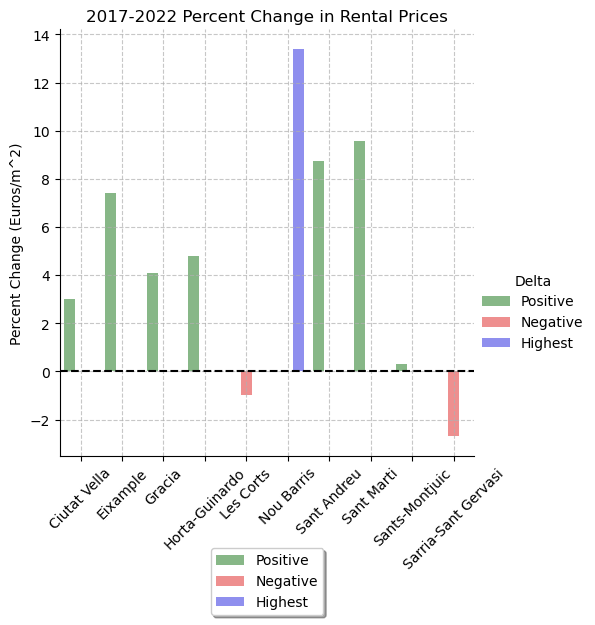

In [348]:
plt.figure(figsize=(10, 6))
sns.catplot(x = 'District', y = 'Percent change', data = rent_price_difference, kind='bar', hue='Delta', palette={'Positive': 'green', 'Negative': 'red', 'Highest': 'blue'}, alpha=0.5)
plt.title('2017-2022 Percent Change in Rental Prices')
plt.xlabel('District')
plt.ylabel('Percent Change (Euros/m^2)')
plt.xticks(ticks=range(len(rent_price_difference['District'].unique())), labels=rent_price_difference['District'].unique(), rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, linestyle='--', linewidth=1.5, color='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True)
plt.show()

The _Nou Barris_ neighbourhood has undergone the most dramatic increase in rental price.

Both _Sant Andreu_ and _Nou Barris_ are on the Northern suburbs of the city and far from the city centre. They are the least touristy neighbourhoods of the city, as denoted by the Ajuntament de Barcelona.

Henceforth, they have been targeted by the Airbnb restrictions to a lesser extent and, in fact, the prices for both rental and sales market have grown comparably more.

Source: _https://ajuntament.barcelona.cat/turisme/sites/default/files/documents/01_relatoria_-_districtes_-_160714_vmomco.pdf_

#### Gross Annual Pay (GAP) analysis

In [349]:
salaries = pd.read_excel("Salarios medios por distrito.xlsx")
salaries.columns = ['District', 'Year', 'GAP']
salaries['District'].unique()

array(['TOTAL\xa0\xa0', '1. Ciutat Vella\xa0\xa0', '2. Eixample\xa0\xa0',
       '3. Sants-Montjuïc\xa0\xa0', '4. Les Corts\xa0\xa0',
       '5. Sarrià-Sant Gervasi\xa0\xa0', '6. Gràcia\xa0\xa0',
       '7. Horta-Guinaró\xa0\xa0', '8. Nou Barris\xa0\xa0',
       '9. Sant Andreu\xa0\xa0', '10. Sant Martí\xa0\xa0'], dtype=object)

In [350]:
for col in salaries.columns:
  salaries[col] = salaries[col].apply(lambda x: re.sub(r'\s\s$','', str(x)))
  if col!='District':
    salaries[col] = salaries[col].apply(lambda x: str(x).replace('.', ''))
    salaries[col] = pd.to_numeric(salaries[col], errors='ignore')
  else:
    salaries[col] = salaries[col].apply(lambda x: re.sub(r'^\d+\.\s(.*)', r'\1', str(x)))
    
salaries['District'].unique()

array(['TOTAL', 'Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts',
       'Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinaró', 'Nou Barris',
       'Sant Andreu', 'Sant Martí'], dtype=object)

In [351]:
salaries['District'] = salaries['District'].replace('TOTAL', 'Barcelona')
salaries['District'] = salaries['District'].replace('Sarrià-Sant Gervasi', 'Sarrià')
salaries['District'] = salaries['District'].replace('Sants-Montjuïc', 'Montjuïc')

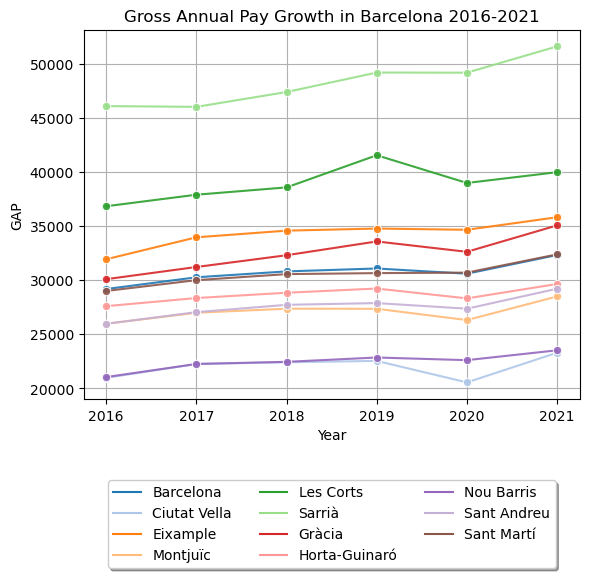

In [352]:
salaries_tot = salaries[salaries['District']=='Barcelona']
sns.lineplot(data=salaries, x='Year', y='GAP', marker='o', hue='District', palette='tab20', alpha=0.9)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('GAP')
plt.title('Gross Annual Pay Growth in Barcelona 2016-2021')
# plt.xticks(salaries_tot['Year'], rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()

In [353]:
df_2017_GAP = salaries[salaries['Year'] == 2017][['District', 'GAP']].rename(columns={'GAP': 'GAP 2017'})
df_2021_GAP = salaries[salaries['Year'] == 2021][['District', 'GAP']].rename(columns={'GAP': 'GAP 2021'})

# Merge on 'Distretto'
GAP_difference = pd.merge(df_2021_GAP, df_2017_GAP, on='District')

In [354]:
df_2021_GAP = df_2021_GAP.reset_index().drop('index', axis=1)
df_2017_GAP = df_2017_GAP.reset_index().drop('index', axis=1)

In [355]:
GAP_difference['Percent change'] = round(((GAP_difference['GAP 2021'] - GAP_difference['GAP 2017']) * 100/ GAP_difference['GAP 2017']),2)
GAP_difference['Delta'] = GAP_difference['Percent change'].apply(lambda x: 'Positive' if x>0 else 'Negative')
GAP_difference.loc[GAP_difference['Percent change'] == max(GAP_difference['Percent change']),'Delta'] = 'Highest'
GAP_difference

,District,GAP 2021,GAP 2017,Percent change,Delta
0,Barcelona,32324,30263,6.81,Positive
1,Ciutat Vella,23285,22244,4.68,Positive
2,Eixample,35815,33959,5.47,Positive
3,Montjuïc,28490,26983,5.58,Positive
4,Les Corts,39981,37899,5.49,Positive
5,Sarrià,51615,46022,12.15,Positive
6,Gràcia,35062,31214,12.33,Highest
7,Horta-Guinaró,29643,28342,4.59,Positive
8,Nou Barris,23510,22247,5.68,Positive
9,Sant Andreu,29203,27038,8.01,Positive


<Figure size 1000x600 with 0 Axes>

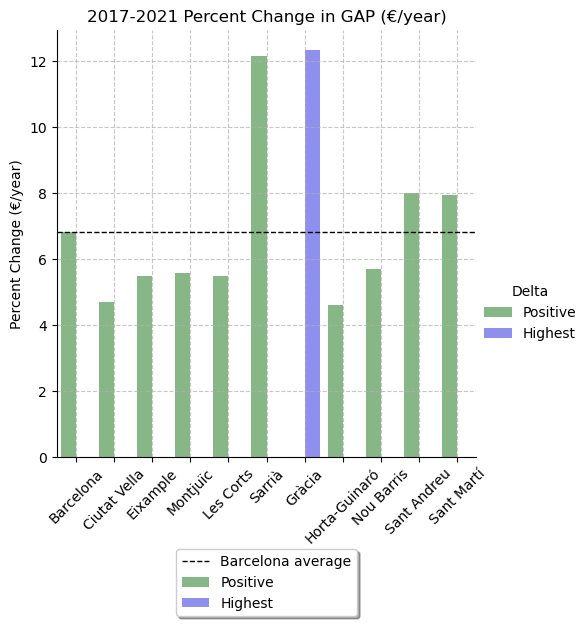

In [356]:
plt.figure(figsize=(10, 6))
sns.catplot(x = 'District', y = 'Percent change', data = GAP_difference, kind='bar', hue='Delta', palette={'Positive': 'green', 'Negative': 'red', 'Highest': 'blue'}, alpha=0.5)
plt.title('2017-2021 Percent Change in GAP (€/year)')
plt.xlabel('District')
plt.ylabel('Percent Change (€/year)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=GAP_difference.loc[0,'Percent change'], linestyle='--', linewidth=1, color='black', label='Barcelona average')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True)
plt.show()

The most touristy neighbourhoods of Barcelona are: _Eixample_ and _Ciutat Vella_

The least touristy neighbourhoods of Barcelona are: _Nou Barris_ and _Sant Andreu_

Source: _https://ajuntament.barcelona.cat/turisme/sites/default/files/documents/01_relatoria_-_districtes_-_160714_vmomco.pdf_

In literature, it is widely stressed how a strict correlation between tourist density and average income of a certain area is not guaranteed to be statistically significant, if it is present at all. That is because there is a wide array of factors impacting salary, many of which have a larger influence than tourism.

In fact, in our analysis of the GAP percent change of Barcelona neighbourhoods from the adoption of the PEUAT regulation (2017) to the most recent data (2021), we do not find a pattern connecting the two variables. Both _Eixample_ and _Ciutat Vella_, which are the two most touristic spots, have exhibited a percent increase of GAP below the city average. Therefore, there is no sign of a significant substitution effect of STR on residential properties.

In [357]:
touristy_districts = listings['neighbourhood_group_cleansed'].value_counts()

# Threshold for grouping smaller slices (e.g., 5% of the total)
threshold = 5 / 100 * touristy_districts.sum()

# Group slices below the threshold
small_slices = touristy_districts[touristy_districts < threshold]
other_sum = small_slices.sum()
new_index = np.where(touristy_districts.index.isin(small_slices.index), 'Others', touristy_districts.index)
touristy_districts_labeled = touristy_districts.copy()
touristy_districts_labeled.index = new_index

In [358]:
# Group the 'Other' labels and sum their values
grouped_districts = touristy_districts_labeled.groupby(touristy_districts_labeled.index).sum()
grouped_districts

Ciutat Vella           4403
Eixample               6714
Gràcia                 1578
Others                 1508
Sant Martí             1752
Sants-Montjuïc         1976
Sarrià-Sant Gervasi     994
Name: neighbourhood_group_cleansed, dtype: int64

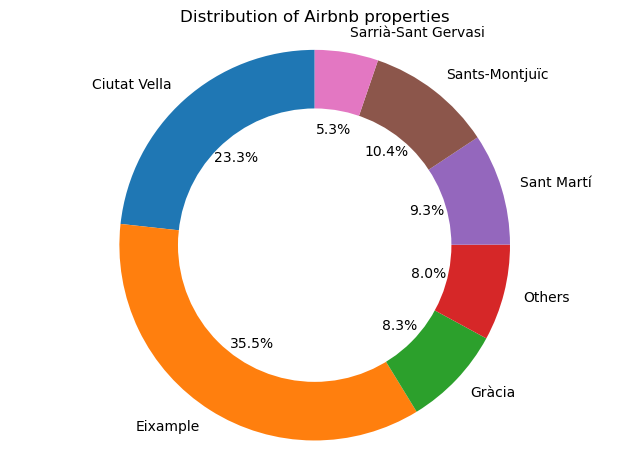

In [359]:
fig1, ax1 = plt.subplots()
ax1.pie(grouped_districts, labels=grouped_districts.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribution of Airbnb properties')
ax1.axis('equal')  
plt.tight_layout()
plt.show()